In [204]:
import pandas as pd

from const import MODEL_BASE_PATH
from util import get_wandb_runs


GROUP_COLS = ["k", "num_rollouts", "model_size"]
GPU_TO_TFLOPS_PER_SECOND = {
    "Tesla T4": 8.141,
    "Tesla L4": 31.3
}
GPU_TO_PRICE_PER_SECOND = {
    "Tesla T4": 0.000164,
    "Tesla L4": 0.000291
}

In [64]:
runs = get_wandb_runs("mcts-v1")

In [351]:
# Create a list to hold runs data
runs_data = []

# Extract data from each run
for run in runs:
    run_data = {
        'id': run.id,
        'name': run.name,
        'state': run.state,
        **run.config,
        **run.summary._json_dict,
    }
    run_data = {k: v for k, v in run_data.items() if not k.startswith('_')}
    runs_data.append(run_data)


runs_df = pd.DataFrame(runs_data).assign(
    tflops_next_token_gen=lambda x: x['next_token_gen_time'] * x['device_name'].map(GPU_TO_TFLOPS_PER_SECOND),
    tflops_seq_gen=lambda x: x['seq_gen_time'] * x['device_name'].map(GPU_TO_TFLOPS_PER_SECOND),
    model_size=lambda x: x['model_path'].str.extract(r'(\d+\.\d+)B').astype(float)
)

In [352]:
aggregations = {
    'tflops_next_token_gen': 'mean',
    'tflops_seq_gen': 'mean',
    'next_token_gen_time': 'mean',
    'seq_gen_time': 'mean',
    'train_reward': 'mean',
    'test_reward': 'mean',
}

agg_df = runs_df.groupby(GROUP_COLS).agg(aggregations).reset_index()

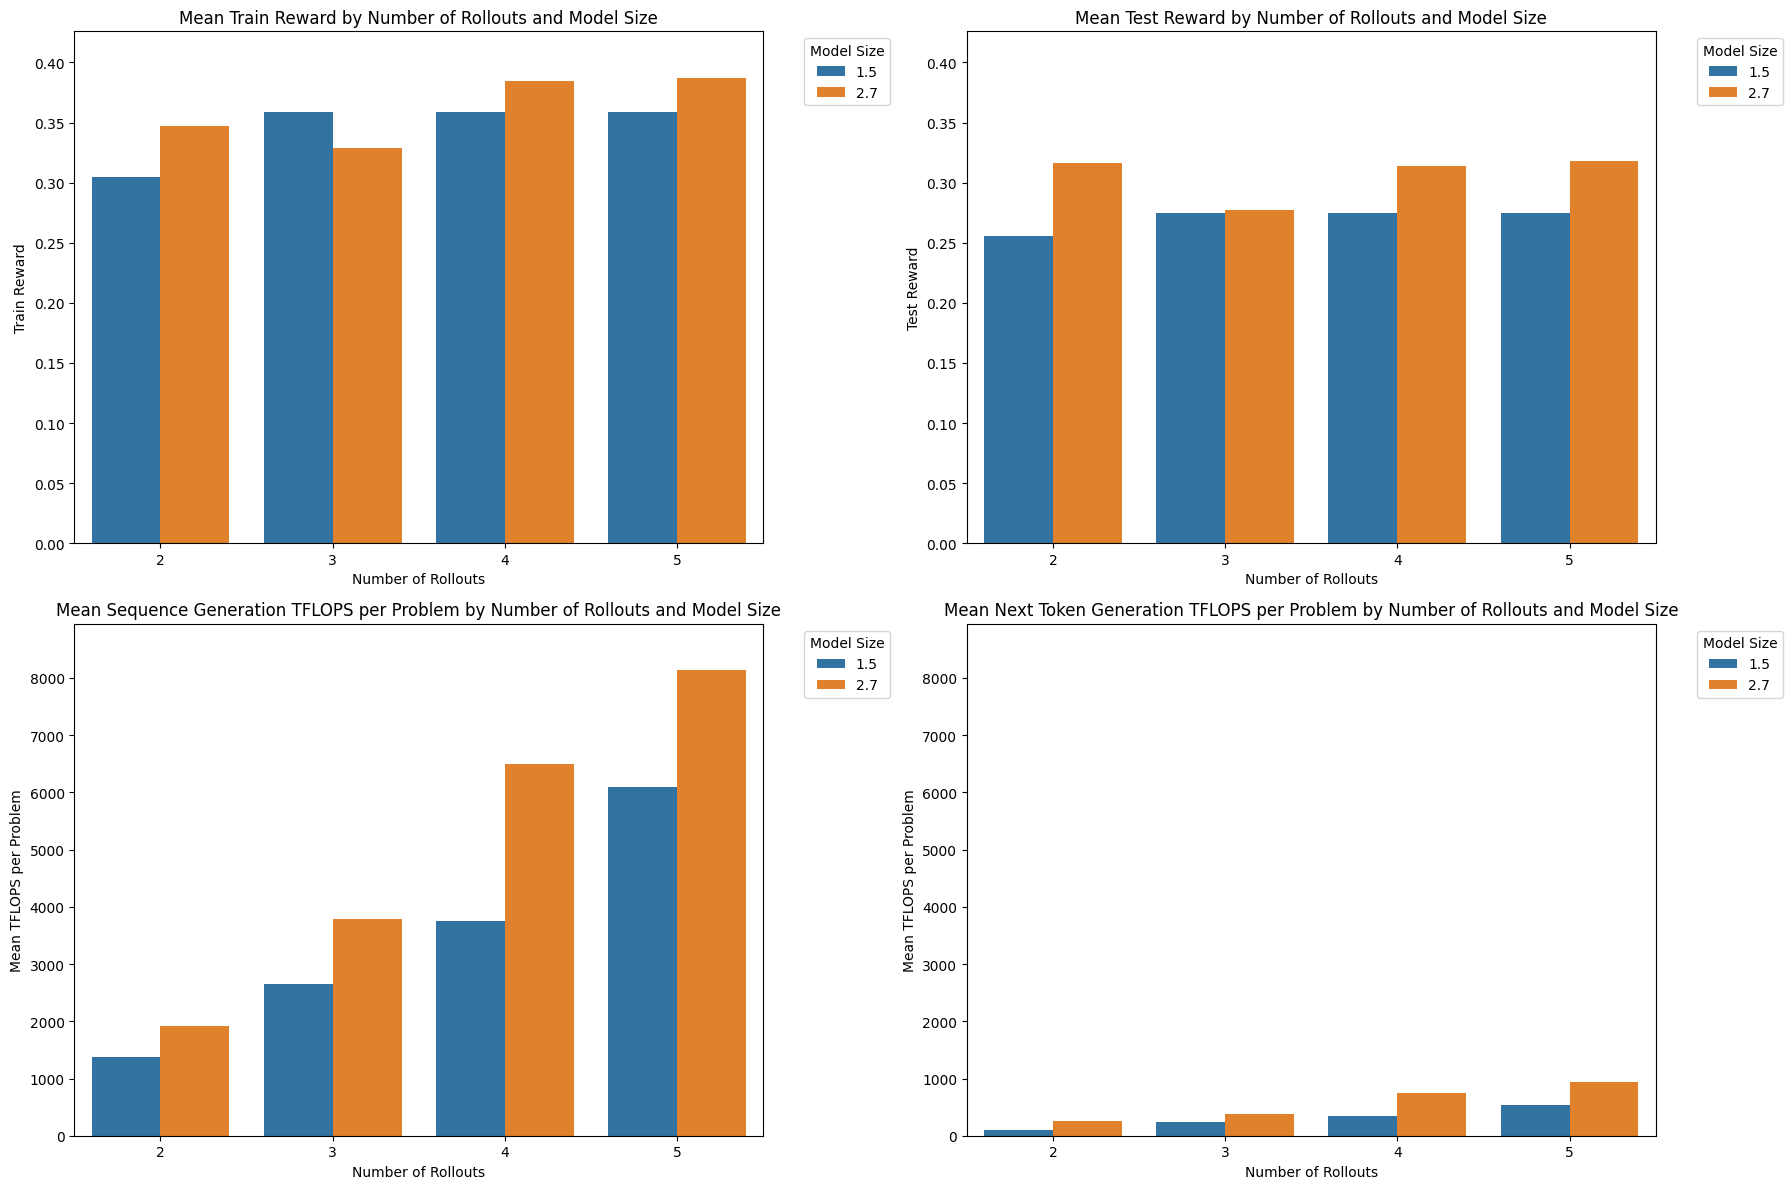

In [355]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

agg_df['model_size'] = agg_df['model_size'].astype('category')

# Create a figure with four subplots arranged in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Determine the y-axis limits for rewards (Train and Test)
max_reward = max(agg_df['train_reward'].max(), agg_df['test_reward'].max())

# First plot (Train Reward)
sns.barplot(ax=axes[0, 0], data=agg_df, x="num_rollouts", y="train_reward", hue="model_size")
axes[0, 0].set_title("Mean Train Reward by Number of Rollouts and Model Size")
axes[0, 0].set_xlabel("Number of Rollouts")
axes[0, 0].set_ylabel("Train Reward")
axes[0, 0].set_ylim(0, max_reward * 1.1)
axes[0, 0].legend(title="Model Size", bbox_to_anchor=(1.05, 1), loc='upper left')

# Second plot (Test Reward)
sns.barplot(ax=axes[0, 1], data=agg_df, x="num_rollouts", y="test_reward", hue="model_size")
axes[0, 1].set_title("Mean Test Reward by Number of Rollouts and Model Size")
axes[0, 1].set_xlabel("Number of Rollouts")
axes[0, 1].set_ylabel("Test Reward")
axes[0, 1].set_ylim(0, max_reward * 1.1)
axes[0, 1].legend(title="Model Size", bbox_to_anchor=(1.05, 1), loc='upper left')

# Determine the y-axis limits for generation TFLOPS (Sequence and Next Token)
max_tflops = max(agg_df['tflops_next_token_gen'].max(), agg_df['tflops_seq_gen'].max())

# Third plot (Sequence Generation TFLOPS)
sns.barplot(ax=axes[1, 0], data=agg_df, x="num_rollouts", y="tflops_seq_gen", hue="model_size")
axes[1, 0].set_title("Mean Sequence Generation TFLOPS per Problem by Number of Rollouts and Model Size")
axes[1, 0].set_xlabel("Number of Rollouts")
axes[1, 0].set_ylabel("Mean TFLOPS per Problem")
axes[1, 0].set_ylim(0, max_tflops * 1.1)
axes[1, 0].legend(title="Model Size", bbox_to_anchor=(1.05, 1), loc='upper left')

# Fourth plot (Next Token TFLOPS)
sns.barplot(ax=axes[1, 1], data=agg_df, x="num_rollouts", y="tflops_next_token_gen", hue="model_size")
axes[1, 1].set_title("Mean Next Token Generation TFLOPS per Problem by Number of Rollouts and Model Size")
axes[1, 1].set_xlabel("Number of Rollouts")
axes[1, 1].set_ylabel("Mean TFLOPS per Problem")
axes[1, 1].set_ylim(0, max_tflops * 1.1)
axes[1, 1].legend(title="Model Size", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# fit models

In [357]:
X = agg_df[['num_rollouts', 'model_size']]

# Model for Mean Sequence Generation TFLOPS
y_seq_gen = agg_df['tflops_seq_gen']
model_seq_gen = LinearRegression()
model_seq_gen.fit(X, y_seq_gen)

# Model for Mean Next Token Generation TFLOPS
y_next_token_gen = agg_df['tflops_next_token_gen']
model_next_token_gen = LinearRegression()
model_next_token_gen.fit(X, y_next_token_gen)

# Model for Test Reward
y_test_reward = agg_df['test_reward']
model_test_reward = LinearRegression()
model_test_reward.fit(X, y_test_reward)

LinearRegression()

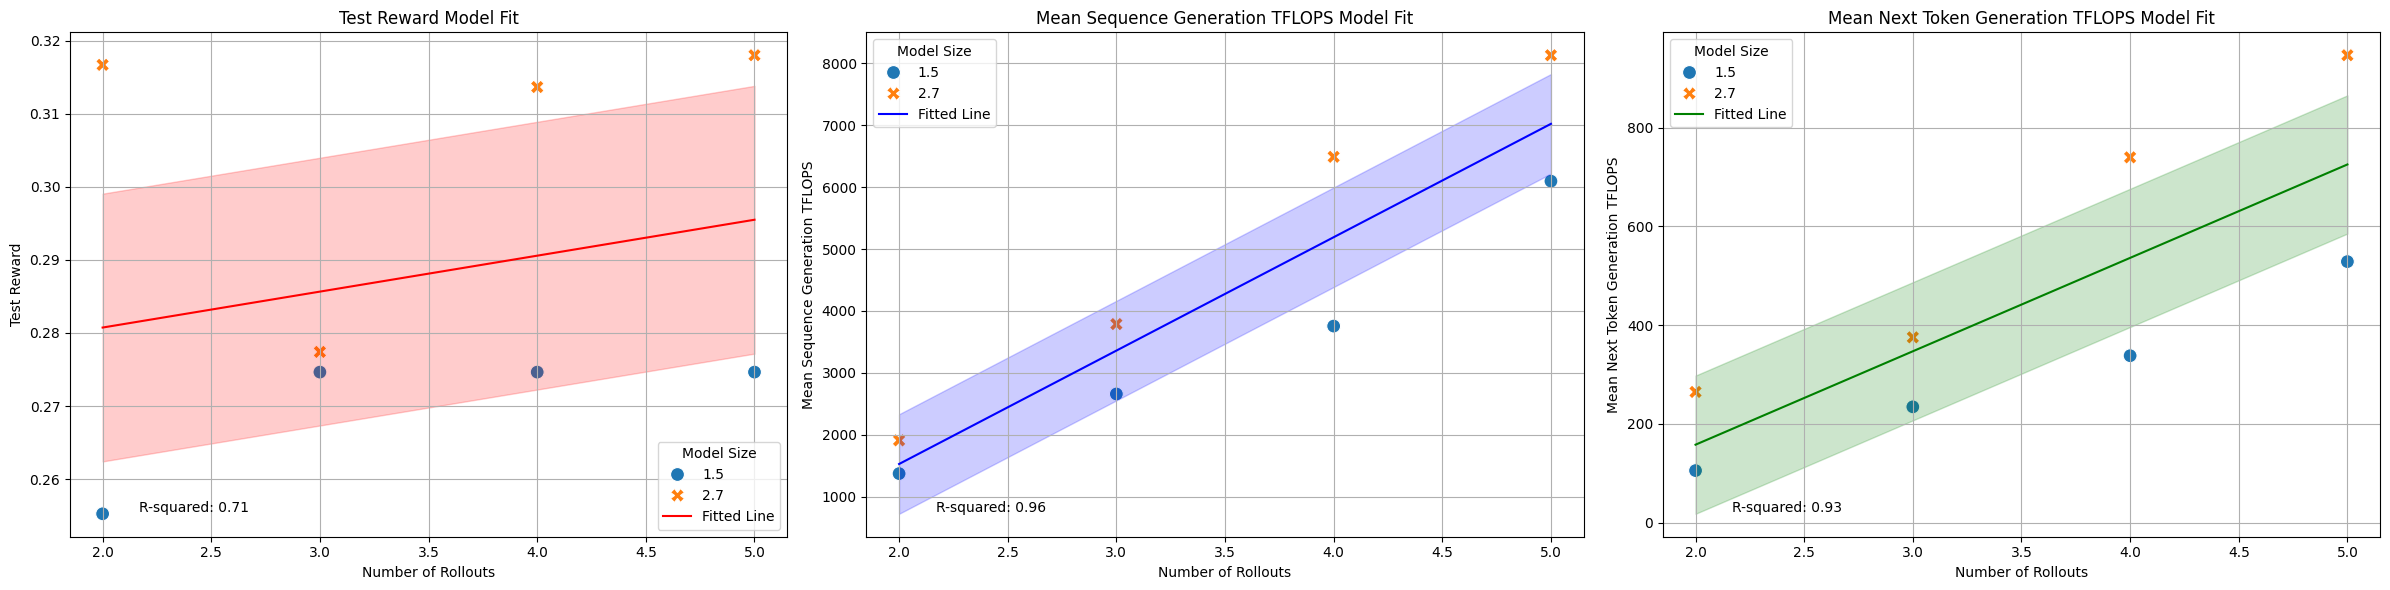

In [358]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming agg_df and the linear regression models are already defined and fitted

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot for Test Reward Model
r2_test_reward = r2_score(agg_df['test_reward'], model_test_reward.predict(X))
sns.scatterplot(ax=axes[0], x='num_rollouts', y='test_reward', data=agg_df, hue='model_size', style='model_size', s=100)
sns.lineplot(ax=axes[0], x='num_rollouts', y=model_test_reward.predict(X), data=agg_df, color='red', label='Fitted Line')
axes[0].set_title('Test Reward Model Fit')
axes[0].set_xlabel('Number of Rollouts')
axes[0].set_ylabel('Test Reward')
axes[0].legend(title='Model Size', loc='best')
axes[0].text(0.25, 0.05, f'R-squared: {r2_test_reward:.2f}', transform=axes[0].transAxes, horizontalalignment='right') # Annotation
axes[0].grid(True)

# Plot for Mean Sequence Generation TFLOPS Model
r2_seq_gen = r2_score(agg_df['tflops_seq_gen'], model_seq_gen.predict(X))
sns.scatterplot(ax=axes[1], x='num_rollouts', y='tflops_seq_gen', data=agg_df, hue='model_size', style='model_size', s=100)
sns.lineplot(ax=axes[1], x='num_rollouts', y=model_seq_gen.predict(X), data=agg_df, color='blue', label='Fitted Line')
axes[1].set_title('Mean Sequence Generation TFLOPS Model Fit')
axes[1].set_xlabel('Number of Rollouts')
axes[1].set_ylabel('Mean Sequence Generation TFLOPS')
axes[1].legend(title='Model Size', loc='best')
axes[1].text(0.25, 0.05, f'R-squared: {r2_seq_gen:.2f}', transform=axes[1].transAxes, horizontalalignment='right') # Annotation
axes[1].grid(True)

# Plot for Mean Next Token Generation TFLOPS Model
r2_next_token_gen = r2_score(agg_df['tflops_next_token_gen'], model_next_token_gen.predict(X))
sns.scatterplot(ax=axes[2], x='num_rollouts', y='tflops_next_token_gen', data=agg_df, hue='model_size', style='model_size', s=100)
sns.lineplot(ax=axes[2], x='num_rollouts', y=model_next_token_gen.predict(X), data=agg_df, color='green', label='Fitted Line')
axes[2].set_title('Mean Next Token Generation TFLOPS Model Fit')
axes[2].set_xlabel('Number of Rollouts')
axes[2].set_ylabel('Mean Next Token Generation TFLOPS')
axes[2].legend(title='Model Size', loc='best')
axes[2].text(0.25, 0.05, f'R-squared: {r2_next_token_gen:.2f}', transform=axes[2].transAxes, horizontalalignment='right') # Annotation
axes[2].grid(True)

plt.tight_layout()
plt.show()

# optimization routine

In [359]:
def predict_valid_test_rewards(num_rollouts_range, model_sizes, max_tflops_budget):
    # Initialize matrices to store the predicted rewards and TFLOPS
    reward_matrix = np.zeros((len(num_rollouts_range), len(model_sizes)))
    tflops_matrix = np.zeros((len(num_rollouts_range), len(model_sizes)))

    # Iterate over combinations and fill the matrices
    for i, num_rollouts in enumerate(num_rollouts_range):
        for j, model_size in enumerate(model_sizes):
            # Predict TFLOPS and reward
            predicted_seq_tflops = model_seq_gen.predict(pd.DataFrame([[num_rollouts, model_size]], columns=['num_rollouts', 'model_size']))[0]
            predicted_next_token_tflops = model_next_token_gen.predict(pd.DataFrame([[num_rollouts, model_size]], columns=['num_rollouts', 'model_size']))[0]
            total_predicted_tflops = predicted_seq_tflops + predicted_next_token_tflops
            predicted_reward = model_reward.predict(pd.DataFrame([[num_rollouts, model_size]], columns=['num_rollouts', 'model_size']))[0]

            # Store the reward and TFLOPS in the matrices
            reward_matrix[i, j] = predicted_reward if total_predicted_tflops <= max_tflops_budget else np.nan
            tflops_matrix[i, j] = total_predicted_tflops

    # Create a DataFrame from the reward matrix
    reward_df = pd.DataFrame(reward_matrix, index=num_rollouts_range, columns=np.round(model_sizes, 2))
    tflops_df = pd.DataFrame(tflops_matrix, index=num_rollouts_range, columns=np.round(model_sizes, 2))

    return reward_df, tflops_df


def plot_rewards_heatmap(num_rollouts_range, model_sizes, max_tflops_budget):
    reward_df, tflops_df = predict_valid_test_rewards(num_rollouts_range, model_sizes, max_tflops_budget)
    
    # Plot the heatmap for rewards
    plt.figure(figsize=(18, 6))
    sns.heatmap(reward_df, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Predicted Reward'})
    plt.title(f'Heatmap of Predicted Reward (Missing cells indicate total TFLOPS > {max_tflops_budget})')
    plt.xlabel('Model Size')
    plt.ylabel('Number of Rollouts')
    plt.show()


def choose_config_given_tflops(num_rollouts_range, model_sizes, max_tflops_budget):
    reward_df, tflops_df = predict_valid_test_rewards(num_rollouts_range, model_sizes, max_tflops_budget)
    if not reward_df.isnull().all().all():
        best_num_rollouts, best_model_size = reward_df.stack().idxmax()
        predicted_test_reward = reward_df.stack().max()
        predicted_tflops = tflops_df.at[best_num_rollouts, best_model_size]
        return {
            "num_rollouts": best_num_rollouts, 
            "model_size": best_model_size, 
            "predicted_test_reward": predicted_test_reward,
            "predicted_tflops": predicted_tflops,
            "tflops_budget": max_tflops_budget, 
        }
    return {}

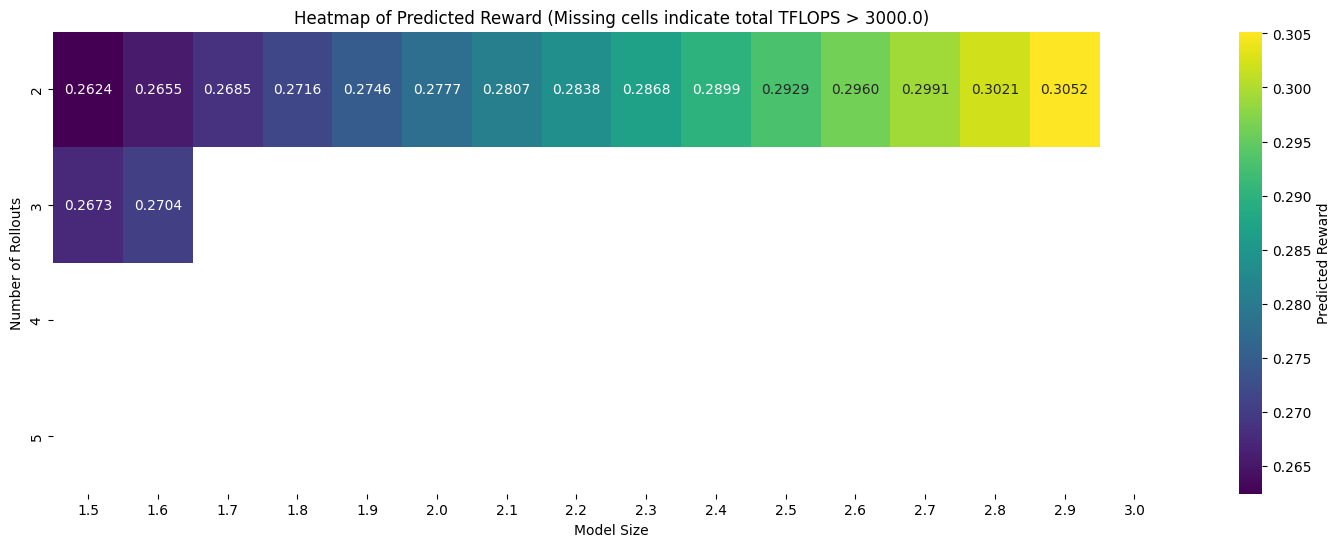

In [360]:
MAX_TFLOPS_BUDGET = 3e3
NUM_ROLLOUTS_RANGE = range(2, 6)
MODEL_SIZES = np.linspace(1.5, 3.0, 16)


plot_rewards_heatmap(NUM_ROLLOUTS_RANGE, MODEL_SIZES, MAX_TFLOPS_BUDGET)

In [361]:
# plot tflops budget to predicted test reward

TFLOPS_BUDGET_RANGE = np.linspace(0, 1e4, 101)

In [362]:
data = []

for budget in TFLOPS_BUDGET_RANGE:
    config = choose_config_given_tflops(NUM_ROLLOUTS_RANGE, MODEL_SIZES, budget)
    data.append(config)


budget_df = pd.DataFrame(data).dropna()

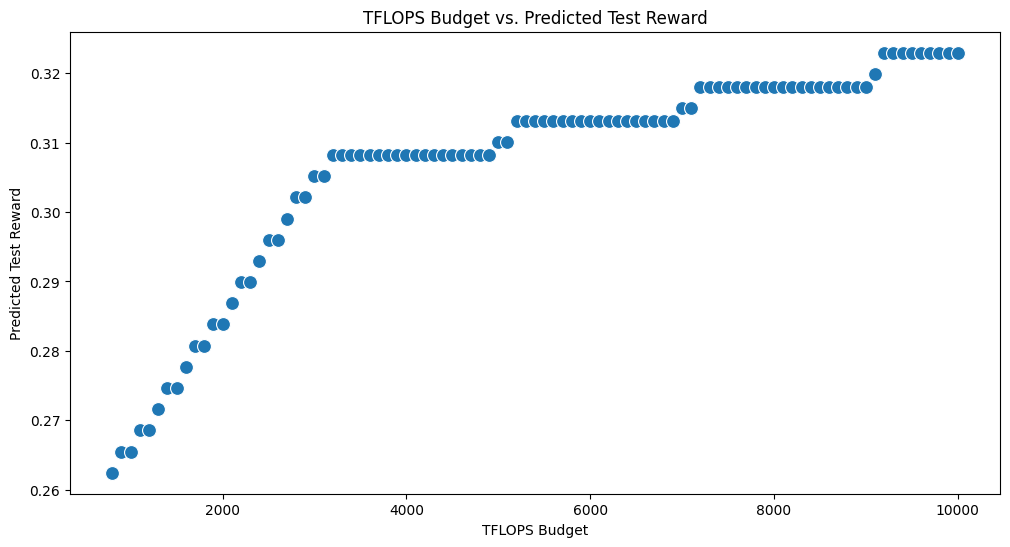

In [363]:
plt.figure(figsize=(12, 6))

sns.scatterplot(x='tflops_budget', y='predicted_test_reward', data=budget_df, s=100)
plt.title('TFLOPS Budget vs. Predicted Test Reward')
plt.xlabel('TFLOPS Budget')
plt.ylabel('Predicted Test Reward')
axes[1].grid(True)

# compute costs in time and $

In [370]:
data = []

for idx, row in budget_df.iterrows():
    for gpu, tflops_per_second in GPU_TO_TFLOPS_PER_SECOND.items():
        d = row.to_dict()
        d['predicted_time'] = d['predicted_tflops'] / tflops_per_second
        d['predicted_dollar_cost'] = d['predicted_time'] * GPU_TO_PRICE_PER_SECOND[gpu]
        d['gpu'] = gpu
        data.append(d)


costs_df = pd.DataFrame(data)